In [26]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import calmap
import numpy as np

### Load Your Data

Download your data [here](http://my.basic-fit.com/information).

Load your data here. It is then filtered to remove duplicates, such as entrance scanners or inviting a friend. 

These erroneously appear as multiple entries for the same person.

In [27]:
my_file = 'sacha.json'

In [28]:
with open(my_file) as f:
    data = json.load(f)
data['visits']
data = pd.DataFrame(data['visits'])
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d-%m-%Y %H:%M')
data['datetime'] = data['datetime'].dt.tz_localize('UTC').dt.tz_convert('Europe/Brussels')
data = data[~(data['datetime'].sort_values().diff() <= pd.Timedelta(minutes=90))]
data = data.set_index('datetime').drop(['date', 'time'], axis=1)

/var/folders/jh/4f00kscx2v7d5f2jk9lm375m0000gn/T/ipykernel_49698/2573045640.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~(data['datetime'].sort_values().diff() <= pd.Timedelta(minutes=90))]


You can remove some clubs if required.

In [29]:
clubs_to_remove = [
    'Basic-Fit Perpignan Boulevard Saint-Assiscle',
    'Basic-Fit Lyon Rue Marius Berliet',
    'Basic-Fit Venissieux Route de Vienne',
]

In [30]:
data = data[~data['club'].isin(clubs_to_remove)]

### Visits per Club

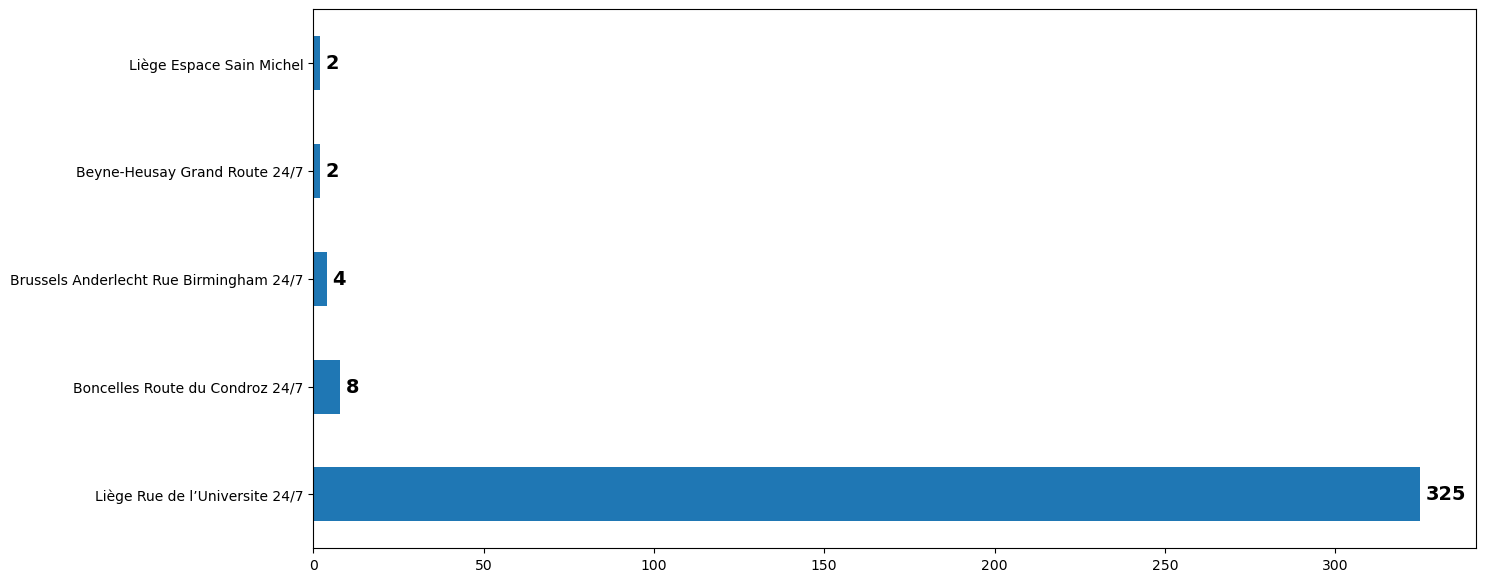

In [31]:
fig, ax = plt.subplots(figsize=(15, 7))
data['club'].apply(lambda x: x.removeprefix('Basic-Fit ')).value_counts().plot(ax=ax, kind='barh')
ax.set_ylabel('')
# Write next to each bar how many times it was visited
for i, v in enumerate(data['club'].value_counts()):
    ax.text(v + 1.5, i - 0.05, str(v), color='black', fontweight='bold', fontdict={'size': 14})

### Visits per Day and Year

Total visits: 341
Total days with >1 visits: 10
Average weekly visits: 2.97 (341 over 115 weeks)
Longest streak: 8 days. Starts on 21-01-2024
Longest inactivity streak: 19 days. Starts on 20-10-2023
------------------------------
Visits in 2021: 17 (~2.83x per week)
Visits in 2022: 156 (~3.00x per week)
Visits in 2023: 148 (~2.85x per week)
Visits in 2024: 20 (~4.00x per week)


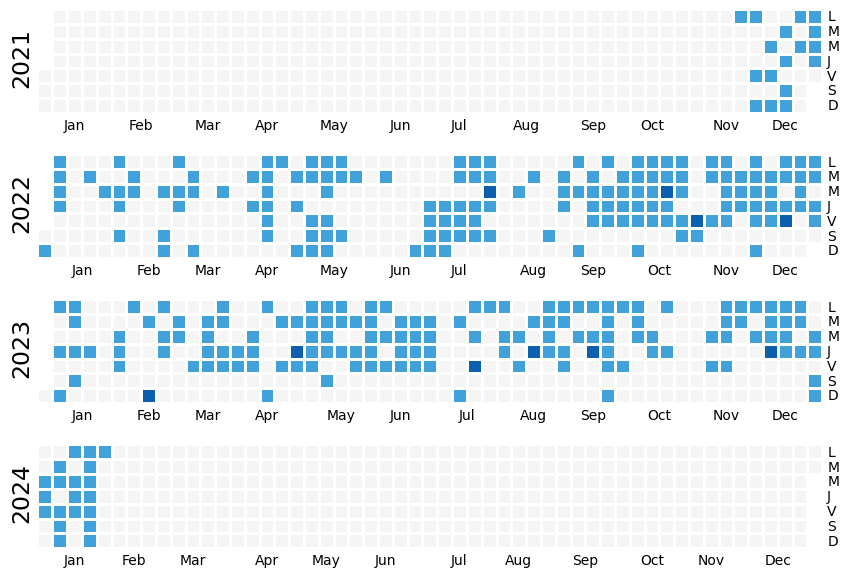

In [44]:
data_perday = data.groupby(pd.Grouper(freq='1D')).agg({'club': 'count'})['club']
min_visits, max_visits = data_perday.min(), data_perday.max()
data_perday.index = data_perday.index.date
data_perday.index = pd.to_datetime(data_perday.index)
num_years = data_perday.index.year.nunique()
fig, ax = plt.subplots(nrows=num_years, ncols=1, figsize=(num_years * 20, 7))
fig.subplots_adjust(hspace=0.4)
print(f"Total visits: {data_perday.sum()}")
print(f"Total days with >1 visits: {data_perday[data_perday > 1].count()}")
# Count number of weeks
num_weeks = data_perday.index.isocalendar().week.groupby(data_perday.index.year).nunique().sum()
print(f"Average weekly visits: {data_perday.sum() / num_weeks:.2f} ({data_perday.sum()} over {num_weeks} weeks)")
# Longest Streak of active days, and longest streak of inactive days
streak_active = 0
max_streak_active = 0
max_streak_active_day = None
streak_inactive = 0
max_streak_inactive = 0
max_streak_inactive_day = None
for i, v in enumerate(data_perday):
    if v > 0:
        streak_active += 1
        if streak_inactive > max_streak_inactive:
            max_streak_inactive = streak_inactive
            max_streak_inactive_day = data_perday.index[i] - pd.Timedelta(days=max_streak_inactive)
        streak_inactive = 0
    else:
        streak_inactive += 1
        if streak_active > max_streak_active:
            max_streak_active = streak_active
            max_streak_active_day = data_perday.index[i] - pd.Timedelta(days=max_streak_active)
        streak_active = 0
if streak_active > max_streak_active:
    max_streak_active = streak_active
    max_streak_active_day = data_perday.index[i] - pd.Timedelta(days=max_streak_active)
if streak_inactive > max_streak_inactive:
    max_streak_inactive = streak_inactive
    max_streak_inactive_day = data_perday.index[i] - pd.Timedelta(days=max_streak_inactive)
print(f"Longest streak: {max_streak_active} days. Starts on {max_streak_active_day.__format__('%d-%m-%Y')}")
print(f"Longest inactivity streak: {max_streak_inactive} days. Starts on {max_streak_inactive_day.__format__('%d-%m-%Y')}")
print("------------------------------")
year_range = range(data.index.year.min(), data.index.year.max() + 1)
for i, year in enumerate(year_range):
    data_y = data_perday[data_perday.index.year == year]
    num_active_weeks = data_y.index.isocalendar().week.nunique()
    print(f"Visits in {year}: {data_y.sum()} (~{data_y.sum() / num_active_weeks:.2f}x per week)")
    
    calmap.yearplot(
        data_perday,
        year=year,
        ax=ax[i],
        cmap=ListedColormap([u'whitesmoke', '#40A2D8', '#0B60B0', '#11235A'][:max_visits + 1]),
        daylabels='LMMJVSD',
        vmin=data_perday.min(),
        vmax=data_perday.max(),
    )
    ax[i].text(-0.035, 0.3, year, transform=ax[i].transAxes, rotation=90, fontdict={'size': 17})
plt.show()

In [33]:
# Show double visits

data_perday[data_perday > 1]
for date in data_perday[data_perday > 1].index:
    s = f"{date.year}-{date.month:02d}-{date.day:02d}"
    print(data[data.index.date == np.datetime64(s)].to_csv(sep='\t', index=True))

datetime	club
2022-07-27 18:28:00+02:00	Basic-Fit Liège Rue de l’Universite 24/7
2022-07-27 13:22:00+02:00	Basic-Fit Liège Rue de l’Universite 24/7

datetime	club
2022-10-19 08:29:00+02:00	Basic-Fit Liège Rue de l’Universite 24/7
2022-10-19 06:34:00+02:00	Basic-Fit Liège Rue de l’Universite 24/7

datetime	club
2022-11-04 17:52:00+01:00	Basic-Fit Liège Rue de l’Universite 24/7
2022-11-04 06:51:00+01:00	Basic-Fit Liège Rue de l’Universite 24/7

datetime	club
2022-12-16 14:29:00+01:00	Basic-Fit Liège Rue de l’Universite 24/7
2022-12-16 09:12:00+01:00	Basic-Fit Liège Rue de l’Universite 24/7

datetime	club
2023-02-19 21:03:00+01:00	Basic-Fit Liège Rue de l’Universite 24/7
2023-02-19 12:14:00+01:00	Basic-Fit Liège Rue de l’Universite 24/7

datetime	club
2023-04-27 20:28:00+02:00	Basic-Fit Liège Rue de l’Universite 24/7
2023-04-27 07:20:00+02:00	Basic-Fit Liège Rue de l’Universite 24/7

datetime	club
2023-07-21 22:54:00+02:00	Basic-Fit Liège Rue de l’Universite 24/7
2023-07-21 18:08:00+02:00